In [1]:
import whisper
import sounddevice as sd
import soundfile as sf
import tempfile
import threading
import time
import pyttsx3
import cv2
import os
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import threading
import mediapipe as mp
import time
import pygame


pygame 2.6.1 (SDL 2.28.4, Python 3.10.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


/Users/luffy_sama/Desktop/Workspace/EE_782/Assignment_2/deepface310/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
# -------- Configuration --------
MODEL_NAME = "medium.en"
RECORD_SECONDS = 4
SAMPLE_RATE = 16000
WAKE_PHRASES = ["guard my room", "guard my room please", "guard", "activate guard", "start guard"]
DISARM_PHRASES = ["stop guard", "disarm", "deactivate guard", "stop guard please", "stop"]

In [3]:
# Set default audio input device (change index if needed)
try:
    sd.default.device = sd.query_devices(kind='input')['name']
except Exception as e:
    print("[audio] Could not set default device:", e)

# persistent webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("[webcam] ERROR: cannot open webcam")

def record_chunk(seconds=RECORD_SECONDS, samplerate=SAMPLE_RATE):
    print(f"[audio] recording {seconds}s...")
    try:
        recording = sd.rec(int(seconds * samplerate), samplerate=samplerate, channels=1)
        sd.wait()
    except Exception as e:
        print("[audio] ERROR:", e)
        return None
    tmp = tempfile.NamedTemporaryFile(suffix=".wav", delete=False)
    sf.write(tmp.name, recording, samplerate)
    return tmp.name

def contains_phrase(text, phrases):
    text = text.lower()
    return any(p in text for p in phrases)

def get_webcam_frame():
    ret, frame = cap.read()
    if not ret:
        return None
    return frame

out_widget = widgets.Output()
display(out_widget)
cap.release()


2025-10-13 19:45:05.302 Python[67191:1626535] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Output()

In [4]:
mp_face_mesh = mp.solutions.face_mesh

BASE_DIR = "enrolled_faces"
os.makedirs(BASE_DIR, exist_ok=True)


import face_recognition

def extract_embedding(image_path):
    img = face_recognition.load_image_file(image_path)
    encodings = face_recognition.face_encodings(img)
    if len(encodings) == 0:
        return None
    return encodings[0]  # 128-D normalized embedding


def enroll_face(person_name, image_paths):
    person_dir = os.path.join(BASE_DIR, person_name)
    os.makedirs(person_dir, exist_ok=True)

    for i, path in enumerate(image_paths):  # keep enumerate
        if not os.path.exists(path):
            print("[enroll] File not found:", path)
            continue
        emb = extract_embedding(path)
        if emb is not None:
            np.save(os.path.join(person_dir, f"{i}.npy"), emb)
            print(f"[enroll] Saved embedding {i+1} for {person_name}")
    print(f"[enroll] Completed enrollment for {person_name} ✅")



In [5]:

enroll_face("Vishal", [
    "enrolled_faces/vishal1.jpg",
    "enrolled_faces/vishal2.jpg",
    "enrolled_faces/vishal3.jpg",
    "enrolled_faces/vishal4.jpg",
    "enrolled_faces/vishal7.jpg",
    "enrolled_faces/vishal8.jpg",
    "enrolled_faces/vishal9.jpg"
])

enroll_face("Darshan", [
    "enrolled_faces/darshan1.jpg",
    "enrolled_faces/darshan2.jpg",
    "enrolled_faces/darshan3.jpg",
    "enrolled_faces/darshan4.jpg",
    "enrolled_faces/darshan5.jpg",
    "enrolled_faces/darshan6.jpg",
    "enrolled_faces/darshan7.jpg"
])


[enroll] Saved embedding 1 for Vishal
[enroll] Saved embedding 2 for Vishal
[enroll] Saved embedding 3 for Vishal
[enroll] Saved embedding 4 for Vishal
[enroll] Saved embedding 6 for Vishal
[enroll] Saved embedding 7 for Vishal
[enroll] Completed enrollment for Vishal ✅
[enroll] Saved embedding 1 for Darshan
[enroll] Saved embedding 3 for Darshan
[enroll] Saved embedding 5 for Darshan
[enroll] Saved embedding 6 for Darshan
[enroll] Saved embedding 7 for Darshan
[enroll] Completed enrollment for Darshan ✅


In [6]:
def recognize_face_with_score(frame, threshold=0.90 ):
    """
    Recognize face from frame by comparing with all enrolled faces.
    Uses majority vote: counts embeddings exceeding threshold per person.
    Returns the person with the maximum count.
    """
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks:
            return "Unknown", frame, 0.0

        # Convert frame from BGR (OpenCV) to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Get FaceNet/Dlib-style 128-D embedding
        encodings = face_recognition.face_encodings(rgb_frame)
        if len(encodings) == 0:
            return "Unknown", frame, 0.0

        emb = encodings[0]

        best_name, best_sim = "Unknown", 0.0
        avg_sim = []

        for person_name in os.listdir(BASE_DIR):
            person_dir = os.path.join(BASE_DIR, person_name)
            if not os.path.isdir(person_dir):
                continue

            sims = []  # store all similarities for this person
            for f in os.listdir(person_dir):
                if not f.endswith(".npy"):
                    continue
                known_emb = np.load(os.path.join(person_dir, f))
                sim = cosine_similarity([emb], [known_emb])[0][0]
                sims.append(sim)

            if sims:  # avoid empty list
                avg_sim = np.mean(sims)  # average similarity for this person
                if avg_sim > best_sim:
                    best_sim = avg_sim
                    best_name = person_name

        # Apply threshold after checking all persons
        if best_sim < threshold:
            best_name = "Unknown"

        return best_name, frame, best_sim


In [7]:
import asyncio
import websockets
import json
import time
import threading

class GuardAgent:
    def __init__(self, cap, ws_uri="ws://localhost:8765"):
        print("[init] loading Whisper model:", MODEL_NAME)
        self.model = whisper.load_model(MODEL_NAME)
        self.tts = pyttsx3.init()
        self.tts.setProperty("rate", 150)
        self.tts.setProperty("volume", 1.0)
        self.guard_mode = False
        self.cap = cap
        self.guard_thread = None
        self.guard_stop_event = threading.Event()
        self.current_name = "Unknown"
        self.face_entry_time = {}
        self.ws_uri = ws_uri
        self.ws_loop = asyncio.new_event_loop()
        self.ws_thread = threading.Thread(target=self.ws_loop.run_forever, daemon=True)
        self.ws_thread.start()
        self.ws_conn = None
        asyncio.run_coroutine_threadsafe(self.connect_ws(), self.ws_loop)

         # Initialize pygame mixer for alarm
        pygame.mixer.init()
        self.alarm_playing = False

    async def connect_ws(self):
        self.ws_conn = await websockets.connect(self.ws_uri)
        print("[ws] Connected to WebSocket server")


    def listen_and_toggle(self):
        # Record audio chunk
        wav_path = record_chunk()  # assume this function exists and returns a path to the wav file
        if not wav_path:
            return

        # Transcribe the audio
        try:
            result = self.model.transcribe(wav_path, language="en")
            transcript = result.get("text", "").strip().lower()
        except Exception as e:
            print("[transcribe] error:", e)
            transcript = ""
        finally:
            os.remove(wav_path)

        print("[heard]", transcript)

        # Activate guard mode if wake phrase is detected
        if not self.guard_mode and contains_phrase(transcript, WAKE_PHRASES):
            self.guard_mode = True
            self.tts.say("Guard mode activated.")
            self.tts.runAndWait()
            self.guard_stop_event.clear()
            self.guard_thread = threading.Thread(target=self.run_guard_mode, daemon=True)
            self.guard_thread.start()

        # Deactivate guard mode if disarm phrase is detected
        elif self.guard_mode and contains_phrase(transcript, DISARM_PHRASES):
            self.guard_mode = False
            self.tts.say("Guard mode deactivated.")
            self.tts.runAndWait()
            self.guard_stop_event.set()
            if self.guard_thread:
                self.guard_thread.join()

    async def send_ws(self, data):
        if self.ws_conn:
            await self.ws_conn.send(json.dumps(data))

    def run_guard_mode(self):
        import mediapipe as mp
        import cv2
        import matplotlib.pyplot as plt
        from IPython.display import display, clear_output

        print("[guard] Running face detection...")
        mp_face = mp.solutions.face_detection
        plt.ion()
        fig, ax = plt.subplots()

        with mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.5) as detector:
            while self.guard_mode and not self.guard_stop_event.is_set():
                ret, frame = self.cap.read()
                if not ret:
                    break

                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = detector.process(rgb)

                if results.detections:
                    for det in results.detections:
                        bboxC = det.location_data.relative_bounding_box
                        ih, iw, _ = frame.shape
                        x1 = int(bboxC.xmin * iw)
                        y1 = int(bboxC.ymin * ih)
                        w = int(bboxC.width * iw)
                        h = int(bboxC.height * ih)
                        x2, y2 = x1 + w, y1 + h

                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        face_crop = frame[max(0, y1):min(ih, y2), max(0, x1):min(iw, x2)]

                        if face_crop.size > 0:
                            name, _, _ = recognize_face_with_score(face_crop)

                        self.current_name = name

                        # Trigger TTS only once for unknown faces
                        if name == "Unknown" and name not in self.face_entry_time:
                            self.tts.say("You have entered an unauthorized area. Please state your purpose.")
                            self.tts.runAndWait()


                        if name not in self.face_entry_time:
                            self.face_entry_time[name] = time.time()

                        duration = time.time() - self.face_entry_time[name]

                        if name == "Unknown" and duration > 120:
                           self.tts.say("Unauthorized person found for more than 2 minutes. Starting alarm.")

                        # Alarm trigger for unknown > 25 seconds
                        if name == "Unknown" and duration > 125:
                            if not self.alarm_playing:
                                pygame.mixer.music.load("alarm.mp3")
                                pygame.mixer.music.play(-1)  # loop indefinitely
                                self.alarm_playing = True
                        else:
                            # Stop alarm if authorized or no face
                            if self.alarm_playing:
                                pygame.mixer.music.stop()
                                self.alarm_playing = False


                        if name not in self.face_entry_time:
                            self.face_entry_time[name] = time.time()

                        duration = time.time() - self.face_entry_time[name]

                        cv2.putText(frame, f"{name}", (x1, y2 + 30),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1.0,
                                    (0, 255, 0) if name != "Unknown" else (0, 0, 255), 2)

                        # Send data to WebSocket
                        data = {
                            "current_name": name,
                            "entry_time": self.face_entry_time[name],
                            "current_time": time.time(),
                            "duration": duration
                        }
                        asyncio.run_coroutine_threadsafe(self.send_ws(data), self.ws_loop)

                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                ax.clear()
                ax.imshow(frame_rgb)
                ax.axis('off')
                clear_output(wait=True)
                display(fig)
                plt.pause(0.01)

        plt.close(fig)



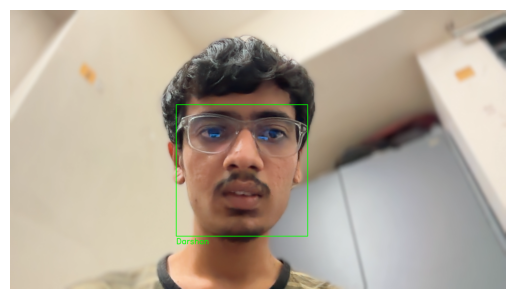

In [ ]:
def main():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("[webcam] cannot open webcam")
        return
    agent = GuardAgent(cap)
    print("Say 'guard my room' to activate. Say 'stop guard' to stop.")

    try:
        while True:
            agent.listen_and_toggle()
            # Optional: show webcam preview when not in guard mode
            if not agent.guard_mode:
                frame = get_webcam_frame()
                if frame is not None:
                    _, encoded_img = cv2.imencode('.png', frame)
                    img_bytes = encoded_img.tobytes()
                    with out_widget:
                        clear_output(wait=True)
                        display(widgets.Image(value=img_bytes, format='png', width=640, height=480))
            time.sleep(0.1)
    except KeyboardInterrupt:
        print("\n[exit] KeyboardInterrupt received — cleaning up.")
    finally:
        if hasattr(agent, 'alarm_playing') and agent.alarm_playing:
            pygame.mixer.music.stop()
            agent.alarm_playing = False
        cap.release()
        print("[exit] done.")

main()


# Testing Face Recognition 

In [ ]:
import os
import cv2
import random

TEST_DIR = "Testing"
NUM_TEST_IMAGES = 10

# Get all image paths in the testing folder
test_images = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]


for img_path in test_images:
    frame = cv2.imread(img_path)
    if frame is None:
        print("[test] Could not read:", img_path)
        continue

    recognized_name, _, sim_score = recognize_face_with_score(frame, threshold=0.95)
    print(f"[test] Image: {os.path.basename(img_path)} --> Recognized as: {recognized_name}, Similarity: {sim_score:.3f}")


I0000 00:00:1760364747.816683       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
I0000 00:00:1760364747.864818       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
I0000 00:00:1760364747.897603       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
I0000 00:00:1760364747.929487       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
I0000 00:00:1760364747.960463       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
I0000 00:00:1760364747.992257       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4


[test] Image: Unknown_7.jpg --> Recognized as: Unknown, Similarity: 0.906
[test] Image: Unknown_6.jpg --> Recognized as: Unknown, Similarity: 0.888
[test] Image: Unknown_4.jpg --> Recognized as: Unknown, Similarity: 0.925
[test] Image: Unknown_5.jpg --> Recognized as: Unknown, Similarity: 0.876
[test] Image: Unknown_1.jpg --> Recognized as: Unknown, Similarity: 0.834
[test] Image: Unknown_2.jpg --> Recognized as: Unknown, Similarity: 0.842


I0000 00:00:1760364748.025952       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
I0000 00:00:1760364748.141611       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4


[test] Image: darshan1.jpg --> Recognized as: Darshan, Similarity: 0.969
[test] Image: Unknown_3.jpg --> Recognized as: Unknown, Similarity: 0.922


I0000 00:00:1760364748.234819       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4


[test] Image: vishal3.jpg --> Recognized as: Vishal, Similarity: 0.954
